# Modèles de prédiction de survie des passagers du Titanic
Dans ce notebook, nous allons tenter de créer deux modèles de prédiction des chances de survie des passagers du Titanic et d'ainsi déterminer quels ont été les variables les plus importantes.

# Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, 
                             confusion_matrix, precision_score)

# Importation & visualisation des données

In [80]:
# Je charge les données et j'enlève les ID qui ne nous servent à rien
Data_Init = pd.read_csv("Data_Titanic.csv").drop(['PassengerId'],axis=1)

# Je retire des potentiels doublons
Data_Init.drop_duplicates(keep='first', inplace=True) 
Data_Init.sample(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
486,1,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0,C93,S
619,0,2,"Gavey, Mr. Lawrence",male,26.0,0,0,31028,10.5,NaN,S
752,0,3,"Vande Velde, Mr. Johannes Joseph",male,33.0,0,0,345780,9.5,NaN,S


In [81]:
# Juste pour unifier les couleurs des différents graphiques
from colour import Color
from matplotlib.colors import ListedColormap, to_rgb, to_hex
Colors = ['#79C3E3', '#2D4955']

# Je crée une colormap matplotlib à partir d'un gradient
def colorFader(c1,c2,mix=0):
    c1=np.array(to_rgb(c1))
    c2=np.array(to_rgb(c2))
    return to_hex((1-mix)*c1 + mix*c2)

gradient = ListedColormap([colorFader('#00252B', '#79C3E3',x/100) for x in range(101)])

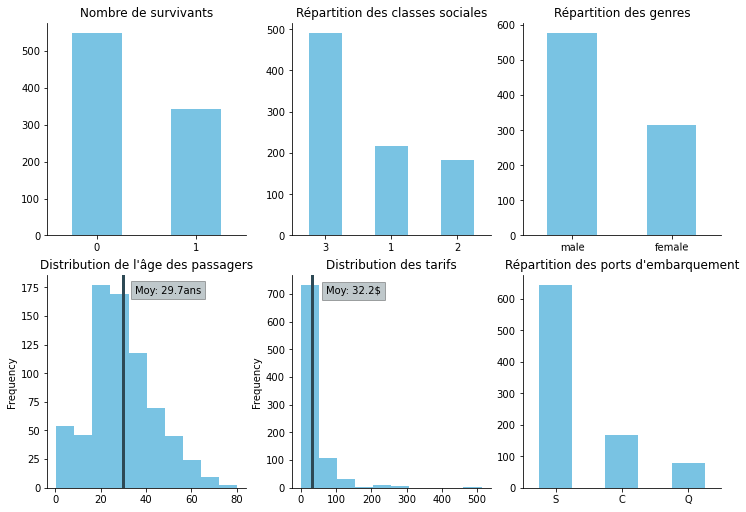

In [82]:
# Visualisation des données
fig, axs = plt.subplots(2,3, figsize=(10,7), constrained_layout = True)

# Le nombre de survivants
_ = Data_Init['Survived'].value_counts().plot.bar(ax=axs[0,0], rot=1, 
                                                  color=Colors[0], 
                                                  title="Nombre de survivants")

# Le nombre de passager selon les classes 1 à 3
_ = Data_Init['Pclass'].value_counts().plot.bar(ax=axs[0,1], rot=1, 
                                                color=Colors[0], 
                                                title="Répartition des classes sociales")

# Le nombre d'hommes et femmes
_ = Data_Init['Sex'].value_counts().plot.bar(ax=axs[0,2], rot=1, 
                                             color=Colors[0], 
                                             title="Répartition des genres")

# La répartition des âges, avec la moyenne
_ = Data_Init['Age'].plot.hist(ax=axs[1,0], 
                               color=Colors[0], 
                               title="Distribution de l'âge des passagers")
_ = axs[1,0].axvline(Data_Init['Age'].mean(), 
                     color=Colors[-1], 
                     lw=3)
_ = axs[1,0].text(x=35, y=170, 
                  s=f"Moy: {np.round(Data_Init['Age'].mean(),2)}ans", 
                  bbox=dict(facecolor=Colors[-1], alpha=0.3))

# La répartition des tarifs, avec la moyenne
_ = Data_Init['Fare'].plot.hist(ax=axs[1,1], 
                                color=Colors[0], 
                                title="Distribution des tarifs")
_ = axs[1,1].axvline(Data_Init['Fare'].mean(), 
                     color=Colors[-1], 
                     lw=3)
_ = axs[1,1].text(x=70, y=700, 
                  s=f"Moy: {np.round(Data_Init['Fare'].mean(),2)}$", 
                  bbox=dict(facecolor=Colors[-1], alpha=0.3))

# Le nombre de passager selon le port d'embarquement
_ = Data_Init['Embarked'].value_counts().plot.bar(ax=axs[1,2], rot=1, 
                                                  color=Colors[0], 
                                                  title="Répartition des ports d'embarquement")

# J'enlève les axes en haut et à droite parce que j'aime pas trop
for col in range(3):
    for row in range(2):
        for spine in ['top', 'right']:
            axs[row,col].spines[spine].set_visible(False)

Nous pouvons voir sur les graphs des disparités au niveau de certaines variables. Par exemple il y a presque 2 fois plus d'hommes, la majorité des gens ont embarqué à Southampton (S) et la classe sociale la plus représentée est la classe 3.

In [83]:
# Récupère le nombre de valeur(s) manquante(s)
nan_values = Data_Init.isna().sum()

# Calcul le pourcentage de valeur(s) manquante(s) et les trie
nan_values = nan_values.sort_values(ascending=False)*100/Data_Init.shape[0]
nan_values.head()

Cabin       77.104377
Age         19.865320
Embarked     0.224467
Survived     0.000000
Pclass       0.000000
dtype: float64

Nous pouvons voir qu'il manque des valeurs dans les variables Age, Cabin et Embarked. Le pourcentage de valeur manquante pour l'âge et le port d'embarquement est raisonnable. Quant aux numéros de cabine, ce pourcentage est plus "problématique".

# Nettoyage des données
Avant de m'occuper des valeurs manquantes, j'ai décider de modifier un peu les données, notamment le genre, les noms et les tickets. Je prends cette décision car ces variables pourront me servir à faire l'imputation de mes données manquantes.

### Les numéros de tickets

In [84]:
# Je définie d'abord une fonction qui récupère seulement le numéro du ticket
def num_ticket(ticket):
    # Le numéro est placé après l'espace dans le nom du Ticket donc on split à ce niveau
    txt = ticket.split(" ")  
    return txt[-1]

# Je crée la colonne Num_Ticket avec la fonction précédemment créée et je vérifie qu'il n'y a que des nombres
Data_Init['Num_Ticket'] = Data_Init['Ticket'].astype(str).map(lambda x: num_ticket(x))
try :
    Data_Init['Num_Ticket'] = Data_Init['Num_Ticket'].astype('float64')
except ValueError:
    display(Data_Init.sort_values(by=['Num_Ticket'], ascending=False).head(6))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Num_Ticket
271,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,LINE
302,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,LINE
597,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,LINE
179,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,LINE
394,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7,G6,S,9549
10,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7,G6,S,9549


Nous pouvons voir que 4 passagers n'ont pas de numéro de ticket. Il s'agit de 4 hommes en 3ème classe ayant embarqué dans le même port. Nous pouvons vérifier la distribution des numéros de tickets sans prendre en compte ces 4 lignes.

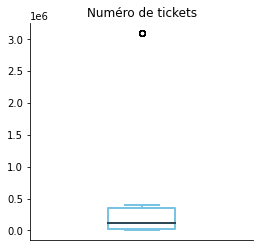

In [85]:
# Je récupère les lignes avec des numéros de ticket
Data_Ticket = Data_Init.loc[Data_Init['Num_Ticket']!='LINE'].copy()
Data_Ticket['Num_Ticket'] = Data_Ticket['Num_Ticket'].astype('float64')

# Je fais un boxplot
ax = Data_Ticket['Num_Ticket'].plot.box(figsize=(4,4), widths=0.3,
                                        title='Numéro de tickets', 
                                        boxprops=dict(linewidth=2, color=Colors[0]), 
                                        whiskerprops=dict(linewidth=2, color=Colors[0]), 
                                        capprops=dict(linewidth=2, color=Colors[0]), 
                                        medianprops=dict(linewidth=2, color=Colors[-1]))
ax.set(xticks=[])
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

En plus des passagers sans tickets, des outliers très prononcés sont présent. Le numéro étant partagé par les familles, je ne peux pas me contenter de remplacer tous les tickets avec la médiane n'importe comment. Je regarde donc le profil des passagers dans les outliers.

In [86]:
Data_Ticket.loc[Data_Ticket['Num_Ticket']>1e6, ['Pclass', 'Embarked']].value_counts()

Pclass  Embarked
3       S           44
dtype: int64

Nous pouvons voir ici que les passagers partagent tous le même profil avec les 4 passagers 'LINE'. A savoir des passagers de 3ème classe ayant tous embarqués à Southampton. Nous pouvons donc regarder les numéros de ticket dans ce profil.

In [87]:
Ticket_outliers = Data_Ticket.loc[(Data_Ticket['Num_Ticket']<1e6) & 
                                  (Data_Ticket['Pclass']==3) & 
                                  (Data_Ticket['Embarked']=='S')]
Tick_Med = Ticket_outliers['Num_Ticket'].median()
# Je vérifie s'il y a des numéros de tickets libres autour de la médiane
Data_Ticket.loc[(Data_Ticket['Num_Ticket']<Tick_Med+20) & 
                (Data_Ticket['Num_Ticket']>Tick_Med+20)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Num_Ticket


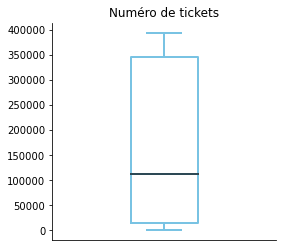

In [88]:
# Je remplace les LINE et outliers par des valeurs proches de la médiane
Data_Init.loc[Data_Init['Num_Ticket']=='LINE', 'Num_Ticket'] = Tick_Med-20
Data_Init['Num_Ticket'] = Data_Init['Num_Ticket'].astype('int64')

Outliers = np.unique(Data_Init.loc[Data_Init['Num_Ticket']>1e6, 'Num_Ticket'])
def new_tick(ticket):
    if ticket in Outliers:
        return Tick_Med+np.where(Outliers==ticket)[0][0]
    else:
        return ticket
Data_Init['Num_Ticket'] = Data_Init['Num_Ticket'].map(lambda x: new_tick(x))

# Je m'assure que ça fonctionne, en faisant un boxplot
ax = Data_Init['Num_Ticket'].plot.box(figsize=(4,4), widths=0.3, 
                                      title='Numéro de tickets', 
                                      boxprops=dict(linewidth=2, color=Colors[0]), 
                                      whiskerprops=dict(linewidth=2, color=Colors[0]), 
                                      capprops=dict(linewidth=2, color=Colors[0]), 
                                      medianprops=dict(linewidth=2, color=Colors[-1]))
ax.set(xticks=[])
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

### Les noms des passagers
La colonne Name n'est pas utilisable en l'état, je décide donc d'extraire les titres et les noms de chaque passager.

In [89]:
# Une fonction pour décomposer les cellules de la colonne Name pour extraire Nom et Titre
def title(Name):
    txt = Name.split(", ")
    Surname = txt[0]
    title = txt[1].split(".")[0]
    return Surname, title

In [90]:
# Je crée les colonnes Surname et Title grâce aux fonctions précédentes
Data_Init['Surname'] = Data_Init['Name'].map(lambda x: title(x)[0])
Data_Init['Title'] = Data_Init['Name'].map(lambda x: title(x)[1])
print(np.unique(Data_Init['Title']))

['Capt' 'Col' 'Don' 'Dr' 'Jonkheer' 'Lady' 'Major' 'Master' 'Miss' 'Mlle'
 'Mme' 'Mr' 'Mrs' 'Ms' 'Rev' 'Sir' 'the Countess']


Nous pouvons voir qu'il y a beaucoup de titres de noblesse, mais pour simplifier les choses, je décide de transformer tous les titres pour n'en garder que 4 : Mr, Mrs, Miss et Master.

In [91]:
# Une fonction pour remplacer les titres rares et n'avoir que 4 titres
def replace_title(data):
    title = data['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['Lady', 'Mme', 'the Countess']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if data['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

# Je remplace les titres dans le DF
Data_Init['Title'] = Data_Init.apply(replace_title, axis=1)
Data_Init.sample(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Num_Ticket,Surname,Title
421,0,3,"Charters, Mr. David",male,21.0,0,0,A/5. 13032,7.7333,NaN,Q,13032.0,Charters,Mr
718,0,3,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q,36568.0,McEvoy,Mr
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,349909.0,Palsson,Master


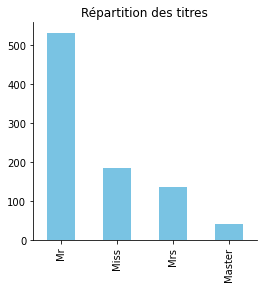

In [92]:
# Je plot le nombre de chaque titre pour voir
ax = Data_Init['Title'].value_counts().plot.bar(color=Colors[0], 
                                                figsize=(4,4), 
                                                title='Répartition des titres')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

Il semblerait qu'il y ait une grande disparité au niveau des titres qui s'explique naturellement par la disparité des genres.

### Le genre des passagers
Enfin, je crée une nouvelle colonne pour renseigner si le(a) voyageur(se) est une femme ou non.

In [93]:
Data_Init['IsFemale'] = pd.get_dummies(Data_Init['Sex'])['female'].astype('int64')

## Les valeurs manquantes
Maintenant que le set de données est plus propre, je regarde s'il existe des valeurs manquantes à combler ou des variables à supprimer.

In [94]:
# Je garde seulement les colonnes nettoyées dans un nouveau DataFrame
Data = Data_Init[['Survived', 'Pclass', 'Surname', 
                  'Title', 'IsFemale', 'Age', 'SibSp', 
                  'Parch', 'Num_Ticket', 'Fare', 
                  'Cabin', 'Embarked']].copy()
Data.sample(3)

,Survived,Pclass,Surname,Title,IsFemale,Age,SibSp,Parch,Num_Ticket,Fare,Cabin,Embarked
355,0,3,Vanden Steen,Mr,0,28.0,0,0,345783.0,9.500,NaN,S
327,1,2,Ball,Mrs,1,36.0,0,0,28551.0,13.000,D,S
761,0,3,Nirva,Mr,0,41.0,0,0,345788.0,7.125,NaN,S


### Port d'embarquement
En ce qui concerne le port d'embarquement, il en manque seulement 2. Je pourrais choisir de les supprimer mais je fais quand même le choix de voir pour les remplacer.

In [95]:
# Affiche les lignes où le port n'est pas renseigné
Data.loc[Data['Embarked'].isnull() == True]

,Survived,Pclass,Surname,Title,IsFemale,Age,SibSp,Parch,Num_Ticket,Fare,Cabin,Embarked
61,1,1,Icard,Miss,1,38.0,0,0,113572.0,80.0,B28,NaN
829,1,1,Stone,Mrs,1,62.0,0,0,113572.0,80.0,B28,NaN


En cherchant les noms sur Google, j'ai très vite trouvé qu'elles ont embarqué dans le port de Southampton (S). Je remplace alors les valeurs manquantes.

In [96]:
# Remplace les NaN par la lettre C dans la colonne Embarked puis vérifie
Data['Embarked'].fillna('S', inplace=True)

### Les cabines
Concernant les cabines, je vais m'attarder un peu. Au vu du grand nombre de valeurs manquantes, nous pourrions simplement supprimer la colonne cabine. Cependant je considère qu'il s'agit d'une information primordiale, car l'emplacement de la cabine a pu influencer l'accès aux canots de sauvetage.
Les cabines étaient réparties sur 7 ponts (A à G) qui correspond à la première lettre de la cabine.

In [97]:
def deck(cabin):
    if type(cabin)==float:
        return('UN')
    else:
        return cabin[0]
Data['Deck'] = Data['Cabin'].map(lambda x: deck(x))

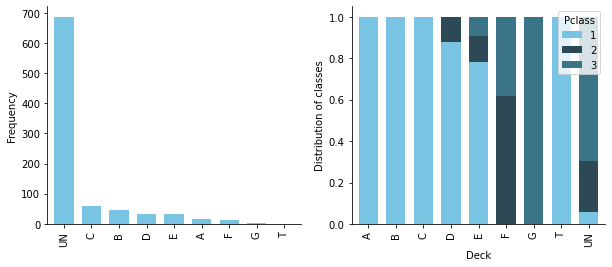

In [98]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

Data['Deck'].value_counts().plot.bar(ax=axs[0], 
                                     color=Colors[0], 
                                     width=0.7)
axs[0].set(ylabel='Frequency')
Deck_Class = Data[['Deck','Pclass']].groupby(['Deck']).value_counts(normalize=True)
Deck_Class.unstack().plot.bar(stacked=True, ax=axs[1], 
                              color=[Colors[0], Colors[1], gradient.colors[50]], 
                              width=0.7)
axs[1].set(ylabel='Distribution of classes')
for col in range(2):
    for spine in ['top', 'right']:
        axs[col].spines[spine].set_visible(False)

Il apparait qu'il manque également des cabines pour des personnes de 1ère et 2nde classe. Or ils dormaient forcément dans des cabines, contrairement à la 3ème classe. Il semble donc que le faible nombre de cabines réside dans l'absence de l'information. Ce manque pourrait être dû à la mort des passagers qui n'ont alors pas pu transmettre l'information. Je rassemble certains ponts ensemble en fonction des classes pour diminuer le nombre de variables.

In [99]:
def group_deck(deck):
    if deck in ['A', 'B', 'C', 'T']:
        return 'ABC'
    elif deck in ['D', 'E']:
        return 'DE'
    elif deck in ['F', 'G']:
        return 'FG'
    else:
        return deck
Data['Decks'] = Data['Deck'].map(lambda x: group_deck(x))

### L'âge des voyageurs

Enfin, il me reste à traiter les valeurs manquantes de l'âge. Je fais une imputation itérative pour prendre en compte les autres paramètres.

In [100]:
# Appelle modèle d'imputation, qui permet de prendre en compte d'autres variables
imput = IterativeImputer(max_iter=10, random_state=87, min_value=0.1)

# Fit le modèle sur les différentes variables numériques seulement
Variables_Num = Data.select_dtypes(include=['float64','int64'])
imput.fit(Variables_Num)

# Transforme les NaN et ne récupère que la colonne correspondant à l'âge
Data.loc[:,'AgeImp'] = imput.transform(Variables_Num)[:,Variables_Num.columns.get_loc('Age')]

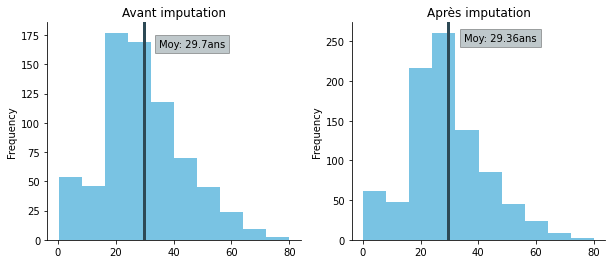

In [101]:
# Je compare les distributions avant et après imputation
fig, axs = plt.subplots(1,2, figsize=[10,4])
_ = Data['Age'].plot.hist(ax=axs[0], 
                          color=Colors[0])
_ = axs[0].axvline(Data['Age'].mean(), 
                   color=Colors[-1], 
                   lw=3)
_ = axs[0].text(x=35, y=165, 
                s=f"Moy: {np.round(Data['Age'].mean(),2)}ans", 
                bbox=dict(facecolor=Colors[-1], alpha=0.3))
_ = axs[0].set_title('Avant imputation')

# Après imputation
_ = Data['AgeImp'].plot.hist(ax=axs[1], 
                             color = Colors[0])
_ = axs[1].axvline(Data['AgeImp'].mean(), 
                   color=Colors[-1], 
                   lw=3)
_ = axs[1].text(x=35, y=250, 
                s=f"Moy: {np.round(Data['AgeImp'].mean(),2)}ans", 
                bbox=dict(facecolor=Colors[-1], alpha=0.3))
_ = axs[1].set_title('Après imputation')

for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[1].spines[spine].set_visible(False)

In [102]:
# Puis je m'assure que les intéractions n'ont pas été perturbées
print(Data.corr()['Age'] - Data.corr()['AgeImp'])

Survived      0.004702
Pclass        0.035502
IsFemale      0.024221
Age           0.000000
SibSp         0.054556
Parch         0.026719
Num_Ticket   -0.027845
Fare          0.001604
AgeImp        0.000000
dtype: float64


Il semblerait que l'imputation n'a pas trop modifié la distribution des âges, et plus important ne semble pas avoir perturbé les interactions avec les autres variables. Je vais donc considérer que l'imputation est satisfaisante !

In [132]:
def class_age(age):
    if age <= 15:
        return 'Enfant'
    elif (age <= 35) & (age > 15):
        return 'Youg_adult'
    elif (age <= 50) & (age > 35):
        return 'Adult'
    else:
        return 'Senior'
    
Data['ClassAge'] = Data['AgeImp'].map(lambda x: class_age(x))

### Derniers ajouts
Nous sommes bientôt prêt pour créer notre modèle de prédiction de survie ! Avant cela je vais créer quelques features supplémentaires pour alimenter mon modèle. Je commence par ajouter une colonne famille et je calcule le tarif par personne, puisque les tarifs actuelles sont partager par toute la famille.

In [133]:
Data.sample(3)

,Survived,Pclass,Surname,Title,IsFemale,Age,SibSp,Parch,Num_Ticket,Fare,Cabin,Embarked,Deck,Decks,AgeImp,Family,Family_Friend,Friend,ScoreName,ClassAge
198,1,3,Madigan,Miss,1,NaN,0,0,370370.0,7.7500,NaN,Q,UN,UN,22.838807,0,0,0,7.000000,Youg_adult
754,1,2,Herman,Mrs,1,48.0,1,2,220845.0,65.0000,NaN,S,UN,UN,48.000000,3,1,0,9.833333,Adult
295,0,1,Lewy,Mr,0,NaN,0,0,17612.0,27.7208,NaN,C,UN,UN,44.306964,0,0,0,16.250000,Adult


In [104]:
# Je transforme le tarif en tarif par personne en comptant le nombre de personne dans la famille
Data['Family'] = Data['SibSp'] + Data['Parch']

Les passagers ne voyageaient pas forcément en famille mais avec des amis ou des servants pour les 1ères classes. Dans ce cas les personnes avaient le même numéro de ticket. Donc j'ajoute une colonne pour ces personnes.

In [105]:
# Je récupère le nombre d'apparition de chaque numéro
All_Tick = Data['Num_Ticket'].value_counts().to_dict()
# Je crée une colonne avec ces nombres
Data['Family_Friend'] = Data['Num_Ticket'].map(lambda x: All_Tick[x]-1)
# Les amis/servants ne sont pas compté dans la famille
Data['Friend'] = Data['Family_Friend'] - Data['Family']
# Certaines personnes vont avoir un chiffre négatif car toute leur famille n'est pas dans le tableau
# Pour eux je mets 0
Data.loc[Data['Friend']<0, 'Friend'] = 0

Il serait également intéressant de savoir si le nom de famille a un impact sur la survie. Notamment dans les familles, peut-être que des noms de familles ont eu plus de chance que d'autre ? Mais la variable surname est inutilisable en l'état, et l'encoder n'est pas envisageable. Donc je décide de récupèrer la longueur des noms et l'addition de la position alphabétique de chaque lettre.

In [110]:
# Je récupère la longueur des noms, et j'additionne la position alphabétique de chaque lettre
def letters(name):
    NAME = name.upper()
    A = np.sum([ord(NAME[x])-64 for x in range(len(NAME))])
    return A/len(NAME)

# Je crée deux nouvelles colonnes
Data['ScoreName'] = Data['Surname'].map(lambda x: letters(x))

In [137]:
Data_Clean = Data.drop(['Surname', 'Age', 'AgeImp', 'Cabin', 'Deck', 'Family_Friend', 'Family'], axis=1)

In [138]:
Data_Clean.head(2)

,Survived,Pclass,Title,IsFemale,SibSp,Parch,Num_Ticket,Fare,Embarked,Decks,Friend,ScoreName,ClassAge
0,0,3,Mr,0,1,0,21171.0,7.2500,S,UN,0,10.000000,Youg_adult
1,1,1,Mrs,1,1,0,17599.0,71.2833,C,ABC,0,12.285714,Adult


### Observation des corrélation
Dernière étape avant de créer les deux modèles de prédiction, nous pouvons regarder la corrélation des différentes variables avec la chance du survie. 

In [114]:
# Je récupère les corrélations entre la survie et les autres variables
corr_data = Data_Clean.corr().drop(['Survived'], axis=0)
# J'ordonne les coefficients dans l'ordre décroissant
corr_plot = corr_data.reindex(corr_data['Survived'].abs().sort_values(ascending=False).index)

Genre_Surv = Data_Clean[['IsFemale','Survived']].groupby(['IsFemale']).value_counts(normalize=True)
Class_Surv = Data_Clean[['Pclass','Survived']].groupby(['Pclass']).value_counts(normalize=True)

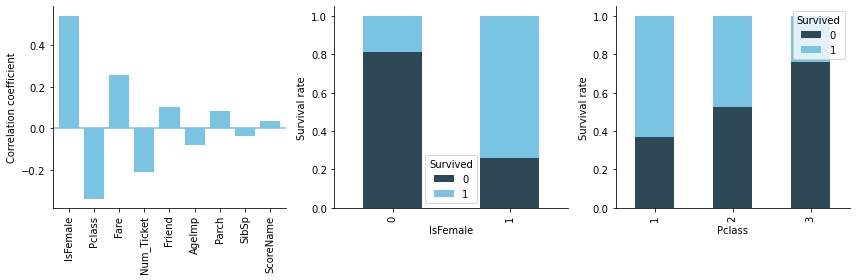

In [115]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
# Je plot les coefficients
corr_plot['Survived'].plot.bar(ax=axs[0], color=Colors[0], width=0.8)
axs[0].axhline(0, color=Colors[0])
axs[0].set(ylabel='Correlation coefficient')

Genre_Surv.unstack().plot.bar(stacked=True, ax = axs[1], color=[Colors[1], Colors[0]])
axs[1].set(ylabel='Survival rate')
Class_Surv.unstack().plot.bar(stacked=True, ax = axs[2], color=[Colors[1], Colors[0]])
axs[2].set(ylabel='Survival rate')

for i in range(3):
    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)
plt.tight_layout()

Nous pouvons voir ici que les variables les plus corrélées sont la classe sociale, le genre, le numéro du ticket et les tarifs. Ainsi, les passagers les plus aisés (Pclass plus faible et Fare plus important) ont un plus grand taux de survie. Près de 80% des femmes ont survécu contre 20% des hommes. Concernant les classes sociales, 60% des premières classes ont survécu contre 50% et 20% pour les 2nd et 3ème classe.

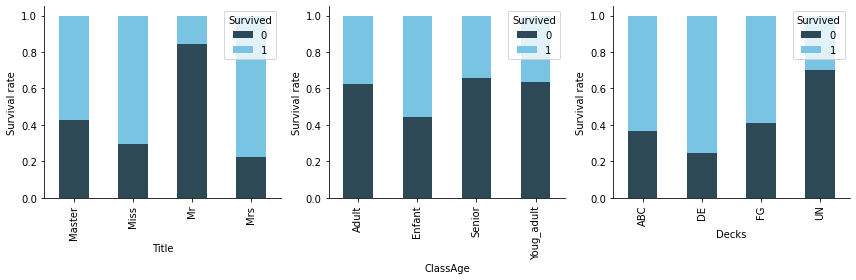

In [136]:
# Répartition de survie en fonction du titre, du port et du pont
Title_Surv = Data_Clean[['Title','Survived']].groupby(['Title']).value_counts(normalize=True)
Emb_Surv = Data_Clean[['Embarked','Survived']].groupby(['Embarked']).value_counts(normalize=True)
Deck_Surv = Data_Clean[['Decks','Survived']].groupby(['Decks']).value_counts(normalize=True)

# Plots 
fig, axs = plt.subplots(1,3, figsize=(12,4))
_ = Title_Surv.unstack().plot.bar(stacked=True, ax = axs[0], color=[Colors[1], Colors[0]])
axs[0].set(ylabel='Survival rate')
_ = Emb_Surv.unstack().plot.bar(stacked=True, ax = axs[1], color=[Colors[1], Colors[0]])
axs[1].set(ylabel='Survival rate')
_ = Deck_Surv.unstack().plot.bar(stacked=True, ax = axs[2], color=[Colors[1], Colors[0]])
axs[2].set(ylabel='Survival rate')
for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[1].spines[spine].set_visible(False)
    axs[2].spines[spine].set_visible(False)
plt.tight_layout()

Il semblerait que le titre et les ponts de résidence des passagers sont corrélés avec les chances de survie. Le titre 'Mr' a ainsi un taux de survie très faible contrairement au titre 'Master' porté par les petits garçons. Nous pouvons ainsi voir que l'adage "les femmes et les enfants d'abord" est confirmé ici.
# Prédiction de chances de survie à bord du Titanic
Enfin, je vais pouvoir créer mes modèles de prédiction de survie à bord du Titanic. Dans un premier temps je récupère la variable prédictive (la survie) et les autres variables.

In [139]:
# J'extrais la variable prédictive et les autres
X_brut = Data_Clean.loc[:,Data_Clean.columns!='Survived']
Y = Data_Clean['Survived']

Je fais un pré-processing des variables X pour standardiser les valeurs numériques (RobustScaler, robuste aux outliers), et encoder les variables catégorielles. Je récupère ensuite un nouveau DataFrame qui pourra être utilisé dans les modèles à venir.

In [140]:
# Transformation numérique, on applique un scaler sur les valeurs numériques
num_transf = RobustScaler()
num_col = make_column_selector(dtype_include=['float64', 'int64', 'int32'])

# Transformation catégorie, on encode les colonnes catégorielles
cat_transf = OneHotEncoder()
cat_col = make_column_selector(dtype_include=['object', 'category'])

# Réalise le preprocessing avec la transformation des colonnes
preprocessor = make_column_transformer((num_transf, num_col), 
                                       (cat_transf, cat_col), 
                                       remainder = 'passthrough', 
                                       verbose_feature_names_out = False)
preprocessor.fit(X_brut)

# Je crée un nouveau DataFrame avec les colonnes transformées
X = pd.DataFrame(preprocessor.transform(X_brut), 
                 columns = preprocessor.get_feature_names_out())
X.head(3)

,Pclass,IsFemale,SibSp,Parch,Num_Ticket,Fare,Friend,ScoreName,Title_Master,Title_Miss,...,Embarked_Q,Embarked_S,Decks_ABC,Decks_DE,Decks_FG,Decks_UN,ClassAge_Adult,ClassAge_Enfant,ClassAge_Senior,ClassAge_Youg_adult
0,0.0,0.0,1.0,0.0,-0.277576,-0.312011,0.0,-0.333966,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-2.0,1.0,1.0,0.0,-0.288370,2.461242,0.0,0.238547,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.703391,-0.282777,0.0,-0.445288,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Regression Logistique
J'ai choisi de réaliser une régression logistique pour commencer. Dans un premier temps je détermine les meilleurs hyperparamètres à l'aide d'un GridSearchCV. 

In [141]:
import warnings
warnings.filterwarnings('ignore')

# Je scinde mes données en échantillon train et test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=87)

In [142]:
# J'initie le modèle de régression
RegLog = LogisticRegression(max_iter=1000,  
                            random_state=87)

# Je réalise un grid search pour les paramètres penalty, C, solver et fit_intercept 
# avec une cross-validation de 10
Grid = GridSearchCV(RegLog, 
                    param_grid={'penalty':['l1','l2'], 
                                'C':np.logspace(-3,3,7), 
                                'solver' :['newton-cg', 'lbfgs', 'liblinear'], 
                                'fit_intercept':[True, False]}, 
                    cv=10, 
                    scoring='accuracy')
Grid.fit(X_train, Y_train)

# Je regarde les meilleurs paramètres
Grid.best_estimator_

LogisticRegression(C=10.0, max_iter=1000, penalty='l1', random_state=87,
                   solver='liblinear')

Avant de regarder les performances de mon modèle, je m'assure que l'apprentissage se réalise de manière correcte avec ces hyperparamètres. Pour cela je réalise une courbe de validation du paramètre C de la régression ainsi qu'une courbe d'apprentissage.

In [143]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

# Je trace la courbe de validation du paramètre C de la régression
train_scores, valid_scores = validation_curve(LogisticRegression(max_iter=1000, 
                                                                 random_state=87, 
                                                                 solver=Grid.best_params_['solver'], penalty='l1'), 
                                              X_train, Y_train, 
                                              param_name="C", 
                                              param_range=np.logspace(-3, 3, 7), 
                                              cv=10)
# Je crée le vecteur C_X qui correspond à mon axe des X.
# Je répète donc 10 fois (le nb de cv) le range de mon paramètre C
C_X = np.repeat(np.logspace(-3, 3, 7), 10, axis=0).T
C_reshape = len(C_X)
# Je reshape mes scores pour les mettre à la suite les uns des autres
train_error = 1 - train_scores.reshape(C_reshape)
valid_error = 1 - valid_scores.reshape(C_reshape)

# Je trace la courbe d'apprentissage de mon modèle
train_sizes, train_scores_learn, valid_scores_learn = learning_curve(Grid.best_estimator_, X_train, Y_train, 
                                                                     train_sizes=np.arange(10,700,100), cv=10)
Learn_X = np.repeat(train_sizes, 10, axis=0).T
Learn_reshape = len(Learn_X)
train_error_learn = 1 - train_scores_learn.reshape(Learn_reshape)
valid_error_learn = 1 - valid_scores_learn.reshape(Learn_reshape)

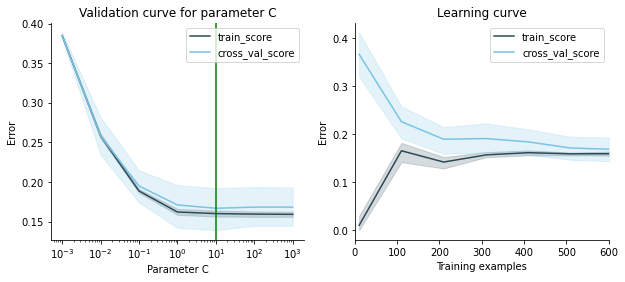

In [144]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

# La courbe de validation
sns.lineplot(C_X, train_error, ax=axs[0], color=Colors[1], label='train_score')
sns.lineplot(C_X, valid_error, ax=axs[0], color=Colors[0], label='cross_val_score')
_ = axs[0].axvline(Grid.best_params_['C'], color='g')
_ = axs[0].set(xscale='log', title="Validation curve for parameter C", xlabel='Parameter C', ylabel='Error')
_ = axs[0].legend()

# La courbe d'apprentissage
sns.lineplot(Learn_X, train_error_learn, ax=axs[1], color=Colors[1], label='train_score')
sns.lineplot(Learn_X, valid_error_learn, ax=axs[1], color=Colors[0], label='cross_val_score')
_ = axs[1].set(title="Learning curve", xlabel='Training examples', ylabel='Error', xlim=[0, 600])
_ = axs[1].legend()

for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[1].spines[spine].set_visible(False)

Sur les deux courbes nous pouvons voir que le taux d'erreur se stabilise et que les valeurs sont similaires entre le set d'entraînement et le set de cross-validation. Le modèle ne fait donc pas d'over ou underfitting ! De plus la courbe d'apprentissage nous montre qu'à partir de 400 valeurs d'entrainement, le modèle n'apprend pas mieux. Notre set d'entraînement étant d'environ 600, c'est parfait ! Regardons à présent la performance de ce modèle.

In [152]:
# J'initie le modèle
RegLog = Grid.best_estimator_
RegLog.fit(X_train, Y_train)
    
# Je récupère les prédictions et probas
probas = RegLog.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, probas[:,1], pos_label=1)

# Je détermine le seuil optimal de prédiction
diff = np.abs(tpr-(1-fpr)) # Je prends la différence absolue entre tpr et fpr
optim_index = np.where(diff==np.sort(diff)[0]) # Je récupère l'index de la différence la plus faible
optim_threshold = thresholds[optim_index] # Je récupère le seuil optimal

Y_pred = (RegLog.predict_proba(X_test)[:,1] >= optim_threshold).astype('int64')

Dans un premier temps je m'assure que le modèle n'est pas trop influencé par le déséquilibre des données au niveau des variables du genre et de la classe sociale.

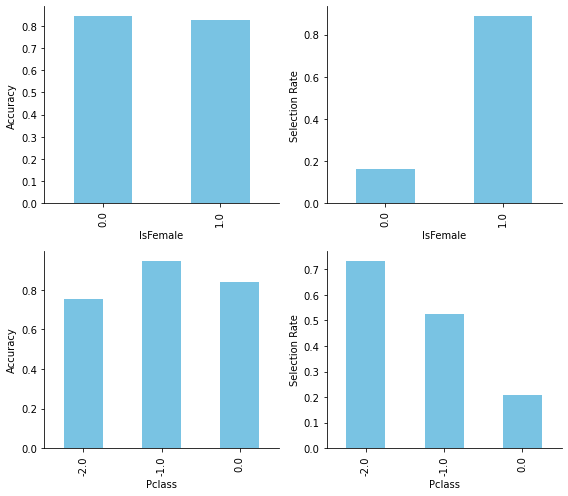

In [146]:
from fairlearn.metrics import MetricFrame, selection_rate, count
# Je regarde les métriques d'accuracy et le taux de sélection
metrics = [accuracy_score, selection_rate]
metrics_name = ['Accuracy', 'Selection Rate']
# Les variables pouvant générer des biais sont le genre et la classe sociale
sensitive_features = ['IsFemale', 'Pclass']
# Je plot les scores en fonction des variables
fig, axs = plt.subplots(2,2, figsize=(8,7))
for met in range(2):
    for i in range(2):
        feature = sensitive_features[i]
        metric_frame = MetricFrame(metrics=metrics[met],
                                   y_true=Y_test,
                                   y_pred=Y_pred,
                                   sensitive_features=X[feature].loc[X_test.index])
        metric_frame.by_group.plot.bar(ax=axs[i,met], color=Colors[0])
        axs[i,met].set(ylabel=metrics_name[met])
        for spine in ['top', 'right']:
            axs[i,met].spines[spine].set_visible(False)
        plt.tight_layout()

Nous pouvons voir que concernant le genre, la precision est similaire entre homme et femme. En revanche la précision est un peu plus perturbée par la classe mais reste très satisfaisante. Enfin le taux de sélection est conforme à la réalité du Titanic à savoir qu'un grand pourcentage des femmes aisées ont survécu. Cependant nous pouvons voir que le seuil de 65% semble être assez punitif envers les hommes. Le but du modèle est 'simplement' de prédire la survie des passagers sur le Titanic afin de déterminer les variables importantes sur une population restreinte connue. Il n'y aurait donc pas vraiment de sens à réduire ces inégalités en passant par une mitigation type DemographicParity qui pourrait en plus réduire la précision du modèle.

Je récupère ensuite différentes métriques d'évaluation afin d'explorer le niveau de performance du modèle.

In [147]:
# Matrice de confusion du modèle
cm = confusion_matrix(Y_test, Y_pred, 
                      labels=RegLog.classes_)

# Récupération des valeurs de la courbe ROC
fpr, tpr, thresholds = roc_curve(Y_test, probas[:,1], pos_label=1)
auc_score = roc_auc_score(Y_test, probas[:,1])

Je réalise une cross-validation du modèle avec un KFold de 10 pour calculer la précision moyenne de mon modèle.

In [155]:
# Je prépare 10 coupes différentes de mes données
KF = KFold(n_splits=10, 
           shuffle=True, 
           random_state=87)
Splits = KF.split(Data_Clean)

acc_LR = []; prec_LR = []; ROC_LR = [] # 3 listes vides pour récupérer les scores du modèle
for train, test in Splits:
    # Je récupère les X et Y pour le train et le test
    X_Train_Reg, X_Test_Reg = X.loc[train], X.loc[test]
    Y_Train_Reg, Y_Test_Reg = Y.loc[train], Y.loc[test]
    
    # Je lance le modèle
    RegLogK = Grid.best_estimator_
    RegLogK.fit(X_Train_Reg, Y_Train_Reg)
    
    # Je récupère les prédictions et probas
    probas_K = RegLogK.predict_proba(X_Test_Reg)
    fpr, tpr, thresholds = roc_curve(Y_Test_Reg, probas_K[:,1], pos_label=1)

    # Je détermine le seuil optimal de prédiction
    diff = np.abs(tpr-(1-fpr)) # Je prends la différence absolue entre tpr et fpr
    optim_index = np.where(diff==np.sort(diff)[0]) # Je récupère l'index de la différence la plus faible
    optim_threshold = thresholds[optim_index] # Je récupère le seuil optimal
    
    Y_pred_K = (RegLogK.predict_proba(X_Test_Reg)[:,1] >= 0.5).astype('int64') #Seuil de prédiction à 0.65% 
    
    # Je récupère les scores d'accuracy, de précision et d'aire sous la courbe ROC
    acc_LR.append(accuracy_score(Y_Test_Reg, Y_pred_K))
    prec_LR.append(precision_score(Y_Test_Reg, Y_pred_K))
    ROC_LR.append(roc_auc_score(Y_Test_Reg, probas_K[:,1]))

Je réalise alors des graphiques pour visualiser la precision de mon modèle.

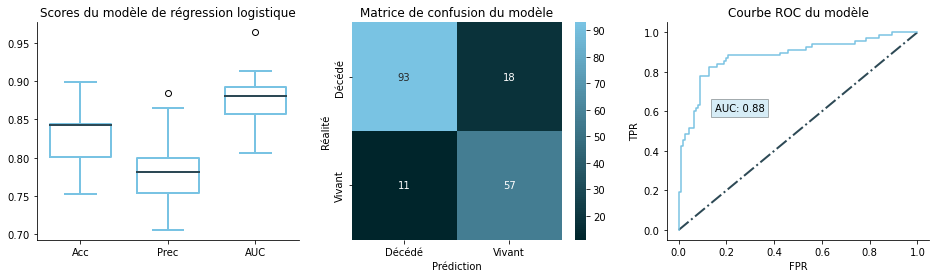

In [156]:
# Je mets les scores dans un DF pour faciliter la création du boxplot
Scores = {'Acc': acc_LR, 'Prec': prec_LR, 'AUC': ROC_LR}
Scores_LR = pd.DataFrame(Scores)

# Boxplots des 3 scores
fig, axs = plt.subplots(1, 3, figsize=(16,4))
Scores_LR.plot.box(ax=axs[0], title='Numéro de tickets', widths=0.7, 
                   boxprops=dict(linewidth=2, color=Colors[0]), 
                   whiskerprops=dict(linewidth=2, color=Colors[0]), 
                   capprops=dict(linewidth=2, color=Colors[0]), 
                   medianprops=dict(linewidth=2, color=Colors[-1]))
axs[0].set_title('Scores du modèle de régression logistique')

# J'enlève toujours les axes à droite et en haut
for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[2].spines[spine].set_visible(False)

    
# Matrice de confusion du modèle
cm = confusion_matrix(Y_test, Y_pred, 
                      labels=RegLog.classes_)
# Plot de la matrice
sns.heatmap(cm, ax=axs[1], xticklabels=['Décédé', 'Vivant'], 
            yticklabels=['Décédé', 'Vivant'], cmap=gradient, 
            annot=True)
_ = axs[1].set(xlabel='Prédiction', ylabel='Réalité', title='Matrice de confusion du modèle')

# Récupération des valeurs de la courbe ROC
fpr, tpr, thresholds = roc_curve(Y_test, probas[:,1], pos_label=1)
auc_score = roc_auc_score(Y_test, probas[:,1])

# Plot de la courbe ROC du modèle
axs[2].plot([0, 1], [0, 1], 
            linestyle='-.', 
            lw=2, 
            color=Colors[-1])
axs[2].plot(fpr, tpr, 
            color=Colors[0])
axs[2].set(title='Courbe ROC du modèle', xlabel='FPR', ylabel='TPR')
_ = axs[2].text(x=0.15, y=0.6, 
                s=f'AUC: {np.round(auc_score,2)}', 
                bbox=dict(facecolor=Colors[0], alpha=0.3))

L'AUC et la précision moyenne semble tout à fait correct. Enfin il nous reste à déterminer les variables ayant le plus gros coefficient dans ce modèle de régression logistique.

In [45]:
# Je crée un DataFrame pour récupérer les différents coefficients du modèle
Coefs = pd.DataFrame(RegLog.coef_.reshape(-1,), 
                     index=X.columns, 
                     columns=['Coefs'])

# Je crée une nouvelle colonne à l'aide de la fonction
Coefs['Odd_ratios'] = Coefs['Coefs'].map(lambda x: (np.exp(x)-1)*100)

# Je range les % de chance de survie dans l'ordre croissant
Ord_Coefs = Coefs.reindex(Coefs['Coefs'].abs().sort_values().index)
Ord_Coefs.tail(3)

,Coefs,Odd_ratios
Title_Master,1.482981,340.605967
Title_Mr,-1.699303,-81.718903
IsFemale,1.976697,621.886291


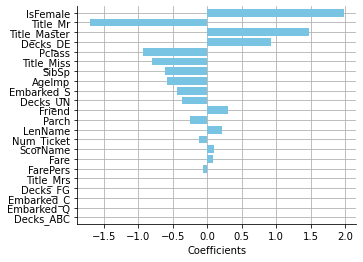

In [46]:
# Je réalise un barplot de ces coefficients
Coef_plot = Ord_Coefs['Coefs'].plot.barh(color=Colors[0], 
                                              align='center', 
                                              width=0.8, 
                                              legend=False, 
                                              zorder=2, figsize=(5,4))
Coef_plot.grid()
Coef_plot.set(xlabel='Coefficients')
for spine in ['top', 'right']:
    Coef_plot.spines[spine].set_visible(False)

Il apparait que les variables les plus importantes pour ce modèle sont le genre (lié au titre par exemple), la classe sociale ainsi que le pont de la cabine. Par exemple une personne en 3ème classe à 50% de chance de survie de moins qu'une personne de seconde classe selon ce modèle.

## Réseau de neurones artificiels
Pour le second modèle, j'ai choisi de réaliser un modèle de prédiction à l'aide d'un réseau de neurones. Je commence par récupérer les meilleurs paramètres avec un GridSearch puis je trace mes courbes de validation et d'apprentissage.

In [47]:
# J'initie le modèle
MLP = MLPClassifier(max_iter=1000, 
                    random_state=87, 
                    activation='logistic')

# Je réalise un grid search pour les hyperparamètres du réseau de neurone
Grid_MLP = GridSearchCV(MLP, 
                        param_grid={'hidden_layer_sizes':[(10,), (50,), (100,), (10,50), (50,50)], 
                                    'solver':['adam', 'sgd'], 
                                    'learning_rate':['constant', 'adaptive'], 
                                    'alpha':np.logspace(-3,1,5)}, 
                        cv=10, 
                        scoring='accuracy')
Grid_MLP.fit(X_train, Y_train)

# Je regarde les meilleurs paramètres
Grid_MLP.best_estimator_

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(10, 50),
              max_iter=1000, random_state=87)

Comme précédemment, je m'assure dans un premier temps du bon apprentissage de mon modèle en traçant les courbes de validation et d'apprentissage.

In [78]:
# La courbe de validation du paramètre alpha
train_scores, valid_scores = validation_curve(MLPClassifier(max_iter=1000, random_state=87, 
                                                            activation='logistic', 
                                                            hidden_layer_sizes=(10,50)), 
                                              X_train, Y_train, 
                                              param_name="alpha", 
                                              param_range=np.logspace(-3,1,5), 
                                              cv=10)
# Je crée le vecteur alpha_X qui correspond à mon axe des X.
# Je répète donc 10 fois (le nb de cv) le range de mon paramètre alpha
alpha_X = np.repeat(np.logspace(-3,1,5), 10, axis=0).T
alpha_reshape = len(alpha_X)
train_error = 1 - train_scores.reshape(alpha_reshape)
valid_error = 1 - valid_scores.reshape(alpha_reshape)

# La courbe d'apprentissage
train_sizes, train_scores_learn, valid_scores_learn = learning_curve(Grid_MLP.best_estimator_, X_train, Y_train, 
                                                                     train_sizes=np.arange(10,700,100), cv=10)
Learn_X = np.repeat(train_sizes, 10, axis=0).T
Learn_reshape = len(Learn_X)
train_error_learn = 1 - train_scores_learn.reshape(Learn_reshape)
valid_error_learn = 1 - valid_scores_learn.reshape(Learn_reshape)

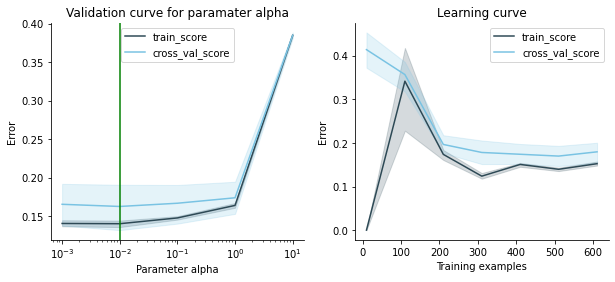

In [49]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

# La courbe de validation du paramètre alpha
sns.lineplot(alpha_X, train_error, ax=axs[0], color=Colors[1], label='train_score')
sns.lineplot(alpha_X, valid_error, ax=axs[0], color=Colors[0], label='cross_val_score')
_ = axs[0].axvline(Grid_MLP.best_params_['alpha'], color='g')
_ = axs[0].set(xscale='log', title="Validation curve for paramater alpha", xlabel='Parameter alpha', ylabel='Error')
_ = axs[0].legend()

# La courbe d'apprentissage du modèle
sns.lineplot(Learn_X, train_error_learn, ax=axs[1], color=Colors[1], label='train_score')
sns.lineplot(Learn_X, valid_error_learn, ax=axs[1], color=Colors[0], label='cross_val_score')
_ = axs[1].set(title="Learning curve", xlabel='Training examples', ylabel='Error')
_ = axs[1].legend()

for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[1].spines[spine].set_visible(False)

Nous pouvons voir ici, comme précédemment que le modèle ne fait pas d'over ou underfitting. Je regarde donc ensuite les performances de mon modèle, en commençant par m'assurer que la disparité des variables ne constitue pas de biais.

In [50]:
# J'utilise le modèle MLP avec les hyperparamètres donnés par le GridSearch
MLP = Grid_MLP.best_estimator_
MLP.fit(X_train, Y_train)

probas = MLP.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, probas[:,1], pos_label=1)
# Je détermine le seuil optimal de prédiction
diff = np.abs(tpr-(1-fpr)) # Je prends la différence absolue entre tpr et fpr
optim_index = np.where(diff==np.sort(diff)[0]) # Je récupère l'index de la différence la plus faible
optim_threshold = thresholds[optim_index] # Je récupère le seuil optimal

Y_pred = (MLP.predict_proba(X_test)[:,1] >= optim_threshold).astype('int64')

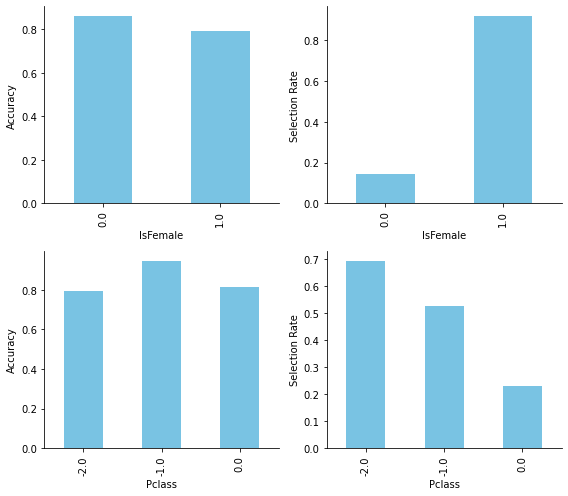

In [51]:
# Je regarde les métriques d'accuracy et le taux de sélection
metrics = [accuracy_score, selection_rate]
metrics_name = ['Accuracy', 'Selection Rate']
# Les variables pouvant générer des biais sont le genre et la classe sociale
sensitive_features = ['IsFemale', 'Pclass']
# Je plot les scores en fonction des variables
fig, axs = plt.subplots(2,2, figsize=(8,7))
for met in range(2):
    for i in range(2):
        feature = sensitive_features[i]
        metric_frame = MetricFrame(metrics=metrics[met],
                                   y_true=Y_test,
                                   y_pred=Y_pred,
                                   sensitive_features=X[feature].loc[X_test.index])
        metric_frame.by_group.plot.bar(ax=axs[i,met], color=Colors[0])
        axs[i,met].set(ylabel=metrics_name[met])
        for spine in ['top', 'right']:
            axs[i,met].spines[spine].set_visible(False)
        plt.tight_layout()

Nous pouvons voir ici, comme avec la régression logistique, que la précision du modèle est satisfaisante sur toutes les variables. Le taux de sélection colle quasi parfaitement à la réalité de la survie de la population du Titanic. Comme pour la régression logistique, je récupère mes métriques d'évaluation et je réalise le modèle plusieurs fois avec un KFold de 10.

In [52]:
# Matrice de confusion
cm = confusion_matrix(Y_test, Y_pred, 
                      labels=MLP.classes_)
# Courbe ROC
fpr, tpr, thresholds = roc_curve(Y_test, probas[:,1], pos_label=1)
auc_score = roc_auc_score(Y_test, probas[:,1])

In [53]:
# Je prépare 10 coupes différentes de mes données
KF = KFold(n_splits=10, 
           shuffle=True, 
           random_state=87)
Splits = KF.split(Data_Clean)

accuracies = []; precisions = []; ROCs = []
# Comme pour la regression logistique, je réalise la cross-validation du modèle MLP
for train, test in Splits:
    X_Train_MLP, X_Test_MLP = X.loc[train], X.loc[test]
    Y_Train_MLP, Y_Test_MLP = Y.loc[train], Y.loc[test]
    MLPK = Grid_MLP.best_estimator_
    MLPK.fit(X_Train_MLP, Y_Train_MLP)
     
    probas_K = MLPK.predict_proba(X_Test_MLP)
    fpr, tpr, thresholds = roc_curve(Y_Test_MLP, probas_K[:,1], pos_label=1)

    # Je détermine le seuil optimal de prédiction
    diff = np.abs(tpr-(1-fpr)) # Je prends la différence absolue entre tpr et fpr
    optim_index = np.where(diff==np.sort(diff)[0]) # Je récupère l'index de la différence la plus faible
    optim_threshold_K = thresholds[optim_index] # Je récupère le seuil optimal
    
    Y_pred_K = (MLP.predict_proba(X_Test_MLP)[:,1] >= optim_threshold_K).astype('int64')
    
    accuracies.append(accuracy_score(Y_Test_MLP, Y_pred_K))
    precisions.append(precision_score(Y_Test_MLP, Y_pred_K))
    ROCs.append(roc_auc_score(Y_Test_MLP, probas_K[:,1]))

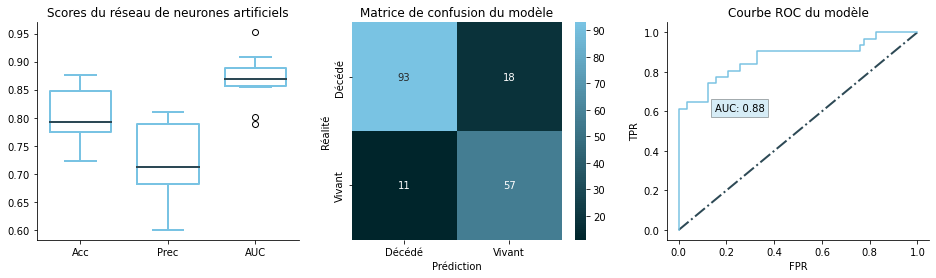

In [54]:
# Je mets les scores dans un DF pour faciliter la création du boxplot
Scores = {'Acc': accuracies, 'Prec': precisions, 'AUC': ROCs}
Scores_MLP = pd.DataFrame(Scores)

# Boxplots des 3 scores
fig, axs = plt.subplots(1, 3, figsize=(16,4))
Scores_MLP.plot.box(ax=axs[0], title='Numéro de tickets', widths=0.7, 
                   boxprops=dict(linewidth=2, color=Colors[0]), 
                   whiskerprops=dict(linewidth=2, color=Colors[0]), 
                   capprops=dict(linewidth=2, color=Colors[0]), 
                   medianprops=dict(linewidth=2, color=Colors[-1]))
axs[0].set_title('Scores du réseau de neurones artificiels')
        
for spine in ['top', 'right']:
    axs[0].spines[spine].set_visible(False)
    axs[2].spines[spine].set_visible(False)
    
# J'affiche la matrice de confusion
sns.heatmap(cm, ax=axs[1], xticklabels=['Décédé', 'Vivant'], 
            yticklabels=['Décédé', 'Vivant'], cmap=gradient, 
            annot=True)
_ = axs[1].set(xlabel='Prédiction', ylabel='Réalité', title='Matrice de confusion du modèle')

# Je trace une courbe ROC du modèle
axs[2].plot([0, 1], [0, 1], 
            linestyle='-.', 
            lw=2, color=Colors[-1])
axs[2].plot(fpr, tpr, color=Colors[0])
axs[2].set(xlabel='FPR', ylabel='TPR', title='Courbe ROC du modèle')
_ = axs[2].text(x=0.15, y=0.6, 
                s=f'AUC: {np.round(auc_score,2)}', 
                bbox=dict(facecolor=Colors[0], alpha=0.3))

Contrairement au modèle de régression logistique, le réseau de neurones n'est pas directement interprétable. Ainsi nous n'avons pas accès aux coefficients. Pour accéder à une interprétation du modèle j'utilise alors la librairie Shap. Comme la fonction predict utilise un seuil de 50% par défaut, je crée une nouvelle fonction pour appliquer le seuil déterminé plus haut.

In [55]:
import shap
shap.initjs()

In [56]:
# Fonction pour placer le seuil de prédiction optimal
def predict_seuil(X):
    predict = (MLP.predict_proba(X)[:,1] >= optim_threshold_K).astype('int64')
    return(predict)

# Je récupère l'explainer de mon modèle et les valeurs shap associées
sample_X = shap.sample(X_test, 100)
explainer = shap.KernelExplainer(predict_seuil, sample_X)
shap_values = explainer.shap_values(sample_X)

  0%|          | 0/100 [00:00<?, ?it/s]

Je peux alors construire un graphique représentant l'impact de chaque variable sur la prédiction.

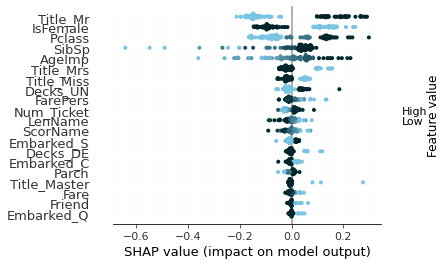

In [57]:
shap.summary_plot(shap_values, sample_X, 
                  feature_names=sample_X.columns, 
                  plot_size=(6,4), 
                  cmap=gradient)

Comme précédemment, nous pouvons voir ici que les variables les plus importantes sont liées au genre et à la classe socialee. De manière intéressante, Shap nous permet également de regarder l'impact de chaque variable pour chaque passager.

In [58]:
shap.plots.force(explainer.expected_value, 
                 shap_values[0], 
                 feature_names=sample_X.columns, 
                 plot_cmap=[Colors[0], Colors[1]])

Dans cet exemple, le modèle prédit que le passager a survecu. Le graphique nous précise que cette décision a été prise puisque la voyageuse était une femme de classe aisée ayant payé son billet assez cher.

## Mes chances de survie
Le modèle fonctionne plutôt bien pour la population du Titanic, cependant je voulais voir mes chances de survie selon ce modèle par curiosité ! Dans ce cas de figure, le taux de sélection très bas des hommes en comparaison des femmes semble un peu injuste puisqu'il n'est pas représentatif de la population mondiale (50.4% d'hommes). A l'inverse la classe sociale est quand même assez représentative de la population et montre bien une mauvaise répartition des richesses en faveur d'une faible proportion de personne ! Par conviction personnelle je vais tout de même modifier mon modèle afin de réduire ces inégalités sociales à l'aide de la descente de gradient exponentielle.

In [59]:
from fairlearn.reductions import DemographicParity, ErrorRate, ExponentiatedGradient
# J'initie le modele à partir de mon modèle de regression logistique
# Je mets en contrainte la parité démographique pour diminuer la disparité dans le taux de sélection
ExpGrad = ExponentiatedGradient(Grid.best_estimator_, constraints=DemographicParity(), max_iter=1000)
ExpGrad.fit(X_train, Y_train, sensitive_features=X_train['Pclass'])
# Je récupère les différents prédicteurs proposés
predictors = ExpGrad.predictors_

In [60]:
# Je récupère les erreurs et disparités de chaque prédicteur proposé
errors, disparities = [], []
for m in predictors:
    def classifier(X):
        return m.predict(X)

    # Récupère les erreur 
    error = ErrorRate()
    error.load_data(X_train, Y_train, sensitive_features=X_train['Pclass'])
    
    # Récupère les disparités
    disparity = DemographicParity()
    disparity.load_data(X_train, Y_train, sensitive_features=X_train['Pclass'])

    # Récupère l'erreur moyenne des 3 classes
    errors.append(error.gamma(classifier)[0])
    # Récupère la plus grande disparité entre les classes
    disparities.append(disparity.gamma(classifier).max())

# Je mets toutes ces données dans un DF
all_results = pd.DataFrame(
    {"predictor": predictors, "error": errors, "disparity": disparities}
)

Une fois que j'ai récupéré mes différents prédicteurs, je dois en sélectionner un qui me permet de diminuer la disparité sans pour autant trop diminuer la performance de mon modèle. Je plot donc les meilleurs prédicteurs pour pouvoir sélectionner celui avec le meilleur compromis.

In [61]:
for row in all_results.itertuples():
    all_results["error"][
        all_results["disparity"] <= row.disparity
    ]

In [62]:
non_dominated = []
# Je garde ensuite seulement les prédicteurs où la disparité est plus faible que l'erreur
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][
        all_results["disparity"] <= row.disparity
    ]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)
len(non_dominated)

3

Seulement 4 prédicteurs ont été sélectionnés.

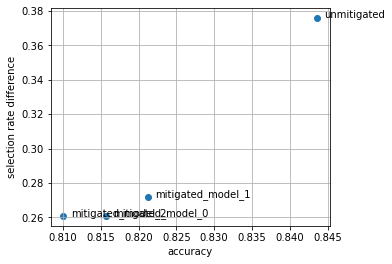

In [63]:
# Je récupère les prédictions de mon modèle de base
metric_frame = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "selection_rate": selection_rate,
        },
        sensitive_features=X_test['Pclass'],
        y_true=Y_test,
        y_pred=Grid.best_estimator_.predict(X_test),
    )
predictions = {"unmitigated": Grid.best_estimator_.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}

# Je récupère les scores d'accuracy et le taux de sélection des 4 prédicteurs
for i in range(len(non_dominated)):
    key = "mitigated_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "selection_rate": selection_rate,
        },
        sensitive_features=X_test['Pclass'],
        y_true=Y_test,
        y_pred=predictions[key],
    )

# Je plot la précision moyenne de chacun des modèles en fonction de la différence maximum de disparité
x = [metric_frame.overall["accuracy"] for metric_frame in list(metric_frames.values())]
y = [metric_frame.difference()["selection_rate"] for metric_frame in list(metric_frames.values())]
keys = list(metric_frames.keys())
plt.figure(figsize=(5,4))
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.001, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")
plt.grid()

Nous pouvons constater ici, que les prédicteurs permettent d'abaisser la disparité de presque 10% sans pour autant diminuer le score. Je décide donc de garder le prédicteur 1 pour calculer mes chances de survie à bord du Titanic.

In [64]:
Data_Clean.sample(1)

,Survived,Pclass,Title,IsFemale,SibSp,Parch,Num_Ticket,Fare,Embarked,Decks,AgeImp,FarePers,Friend,LenName,ScorName
51,0,3,Mr,0,0,0,39886.0,7.8,S,UN,21.0,7.8,0,9,157


Je pousse ma curiosité jusqu'au bout et je vais comparer mes chances de survie en étant accompagné ou non par ma famille

In [65]:
J_Alone = pd.DataFrame([(2, 'Mr', 0, 0, 0, 18282, 20.0, 'C', 'FG', 28.0, 20.0, 1, letters('Verneuil')[0], letters('Verneuil')[1])], columns=Data_Clean.columns[1:])
J_Fam = pd.DataFrame([(2, 'Mr', 0, 2, 2, 18282, 50.0, 'C', 'FG', 28.0, 10.0, 0, letters('Verneuil')[0], letters('Verneuil')[1])], columns=Data_Clean.columns[1:])
Jeremy = pd.concat([J_Alone, J_Fam])

# Je fais le préprocessing comme précédemment
J_Transf = pd.DataFrame(preprocessor.transform(Jeremy), 
                        columns = preprocessor.get_feature_names_out())
J_Transf.head()

,Pclass,IsFemale,SibSp,Parch,Num_Ticket,Fare,AgeImp,FarePers,Friend,LenName,...,Title_Miss,Title_Mr,Title_Mrs,Embarked_C,Embarked_Q,Embarked_S,Decks_ABC,Decks_DE,Decks_FG,Decks_UN
0,-1.0,0.0,0.0,0.0,-0.286306,0.240186,-0.063094,0.712690,1.0,0.333333,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.0,0.0,2.0,2.0,-0.286306,1.539472,-0.063094,0.103553,0.0,0.333333,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [71]:
New_modele = non_dominated[0]
New_modele.fit(X_train, Y_train)

probas = New_modele.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, probas[:,1], pos_label=1)
# Je détermine le seuil optimal de prédiction
diff = np.abs(tpr-(1-fpr)) # Je prends la différence absolue entre tpr et fpr
optim_index = np.where(diff==np.sort(diff)[0]) # Je récupère l'index de la différence la plus faible
optim_threshold = thresholds[optim_index] # Je récupère le seuil optimal

In [72]:
# Je récupère les valeurs shap pour l'interprétabilité
def predict_mit_seuil(X):
    predict = (New_modele.predict_proba(X)[:,1] >= optim_threshold).astype('int64')
    return(predict)

explainer = shap.KernelExplainer(predict_mit_seuil, sample_X)
shap_val_Jeremy = explainer.shap_values(J_Transf)

  0%|          | 0/2 [00:00<?, ?it/s]

In [73]:
# Si je suis seul
shap.plots.force(explainer.expected_value, shap_val_Jeremy[0], 
                 feature_names=J_Transf.columns, 
                 plot_cmap=[Colors[0], Colors[1]])

In [74]:
# Si je suis avec ma famille
shap.plots.force(explainer.expected_value, shap_val_Jeremy[1], 
                 feature_names=J_Transf.columns, 
                 plot_cmap=[Colors[0], Colors[1]])

In [75]:
print(New_modele.predict_proba(J_Transf)[:,1])
print(RegLog.predict_proba(J_Transf)[:,1])

[0.45418799 0.09486191]
[0.43823249 0.10727258]


De manière intéressante, je constate que mon modèle prédit que si je voyage seul, j'ai presque 2 fois plus de chance de survivre que si je voyage avec ma famille. Je note donc qu'il est préférable que je voyage sans eux !